In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util
from inv import model
from inv import process

2024-02-05 15:30:47.001741: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-05 15:30:48.236337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-05 15:30:48.236561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-05 15:30:48.236577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [2]:
path = __datadir__("OPENGLOT/RepositoryI/Vowel_O/O_normal_200Hz.wav")

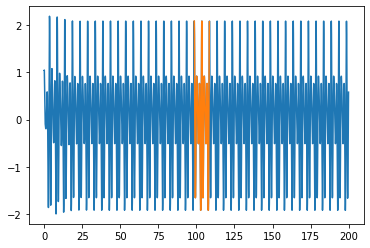

In [3]:
from scipy.io import wavfile
fs, rawdata = wavfile.read(path)

data = process.process_data(rawdata, fs, max_NP=3)

plot(data['fullt'], data['fulld'])
plot(data['t'], data['d'])

(array([ 98.6, 103.6, 108.6]),
 array([[          nan,           nan,           nan],
        [ 585.08020774, 2364.10460151, 2958.49149314],
        [ 585.07962237, 2364.10900539, 2958.51707931]]))

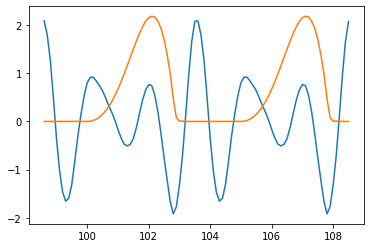

In [4]:
plot(data['t'], data['d'])
plot(data['t'], data['aux'])

data['pulse_estimate'], data['F_estimate']

`F_estimate` from Praat is off the mark and our prior will follow it too eagerly, missing low freq poles which are then emulated by wiggly GFs. Setting it to missing for $K=3$ also results in our prior being too constrained. So for now we simply set the estimates to their true values.

In [5]:
F_true = np.vstack([[570., 840., 2410.]]*3)
data['F_estimate'] = F_true

[Memory]6.6s, 0.1min    : Loading get_aplawd_training_pairs_subset...


[Memory]22.9s, 0.4min   : Loading run_nested...
[Memory]24.7s, 0.4min   : Loading run_nested...
[Memory]26.5s, 0.4min   : Loading run_nested...
[Memory]28.3s, 0.5min   : Loading run_nested...
NP = 3
Number of data points: 100
Number of model dimensions: 35


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 AllPoleFilter(3))

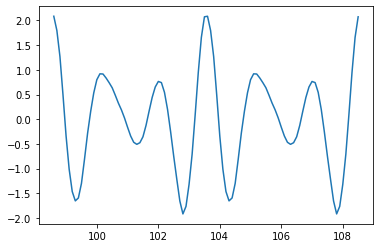

In [6]:
from inv import model
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.AP(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

ftril = process.get_source_amplitudes_tril(
    data['NP'], source_config['kernel_M']
)

hyper = dict(
    meta = dict(
        noiseless_estimates = False,
        bf = constants.BOUNDARY_FACTOR,
        rho = .5, # Peak picking
        inference_method = "nested_sampling",
        inference_method_options = {}
    ),
    ftril = ftril,
    data = data,
    source = source_config,
    filter = vtfilter
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [7]:
def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]29.4s, 0.5min   : Loading get_aplawd_training_pairs_subset...
[Memory]30.0s, 0.5min   : Loading posterior_of_fitted_lf_values...
[Memory]30.1s, 0.5min   : Loading run_nested...
[Memory]30.3s, 0.5min   : Loading get_aplawd_training_pairs_subset...
[Memory]35.6s, 0.6min   : Loading posterior_of_fitted_TFB_values...
[Memory]35.8s, 0.6min   : Loading run_nested...
[Memory]35.8s, 0.6min   : Loading get_vtrformants_training_data...
[Memory]44.7s, 0.7min   : Loading run_nested...
[Memory]45.8s, 0.8min   : Loading run_nested...
[Memory]46.9s, 0.8min   : Loading run_nested...
[Memory]48.0s, 0.8min   : Loading run_nested...
[Memory]48.1s, 0.8min   : Loading get_vtrformants_training_data...


({'noise_sigma': DeviceArray(0.08993853, dtype=float64),
  'delta': DeviceArray(0.61986916, dtype=float64),
  'source': DeviceArray([[6.96733852, 0.52276574, 4.75171947, 0.93836769],
               [6.84606006, 0.47630152, 5.01530733, 0.93472002],
               [8.02811245, 0.5382138 , 5.00240385, 0.94876667]],            dtype=float64),
  'filter': DeviceArray([[ 646.48574482, 1019.40514994, 2560.02504302,   67.39128201,
                 173.2375489 ,  514.94405919],
               [ 638.10523918, 1015.37522074, 2537.09353081,   70.12543058,
                 174.25909411,  513.4300194 ],
               [ 642.43213235, 1003.76056133, 2502.7625442 ,   73.47260218,
                 178.99511035,  536.9398956 ]], dtype=float64),
  'g': DeviceArray([[-1.31058077],
               [-0.26334585],
               [-0.58842266]], dtype=float64)},
 DeviceArray(-77.68683727, dtype=float64))

## Test NS algorithm

In [8]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)

def hack(w):
    wfull = jnp.zeros(len(w) + 1)
    wfull = wfull.at[1:].set(w)
    return wfull

def forward(w):
    w = hack(w)
    theta = theta_bijector.forward(w)
    return theta
    
@jax.jit
def loglike(w):
    theta = forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper) - 1
ndim

[Memory]56.5s, 0.9min   : Loading posterior_of_fitted_lf_values...
[Memory]56.5s, 0.9min   : Loading run_nested...
[Memory]56.6s, 0.9min   : Loading posterior_of_fitted_TFB_values...
[Memory]56.6s, 0.9min   : Loading run_nested...


34

In [9]:
w = ptform(rand(ndim))
loglike(w), forward(w)

(DeviceArray(-143.94346745, dtype=float64),
 {'noise_sigma': DeviceArray(0.0917665, dtype=float64),
  'delta': DeviceArray(0.54628101, dtype=float64),
  'source': DeviceArray([[3.50265588, 0.47152879, 5.00490288, 0.47128545],
               [3.27133027, 0.46296545, 4.93817577, 0.48712769],
               [3.1273631 , 0.45440424, 5.4093588 , 0.48719711]],            dtype=float64),
  'filter': DeviceArray([[ 541.33379525,  931.60545511, 2292.67209525,   80.57035124,
                  67.68163554,  208.07885599],
               [ 549.17294043,  955.55722695, 2355.0918483 ,   83.7343299 ,
                  73.15893328,  295.29290889],
               [ 541.70073359,  969.18449689, 2390.88985028,   85.02996047,
                  73.09884407,  357.08135709]], dtype=float64),
  'g': DeviceArray([[1.51743506],
               [0.81396944],
               [1.28694507]], dtype=float64)})

In [10]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

# Could use 10% stopping criteria as in Petrosyan+ 2023
sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=3*ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

1242it [1:12:37,  3.82s/it, bound: 29 | nc: 197 | ncall: 180410 | eff(%):  0.688 | loglstar:   -inf < 88.651 <    inf | logz: 77.652 +/-  0.290 | dlogz:  2.888 >  0.111]

Summary
nlive: 105
niter: 5538
ncall: 1224130
eff(%):  0.461
logz: 183.953 +/-  0.715


None

'Information (bans)'

18.207518335163073

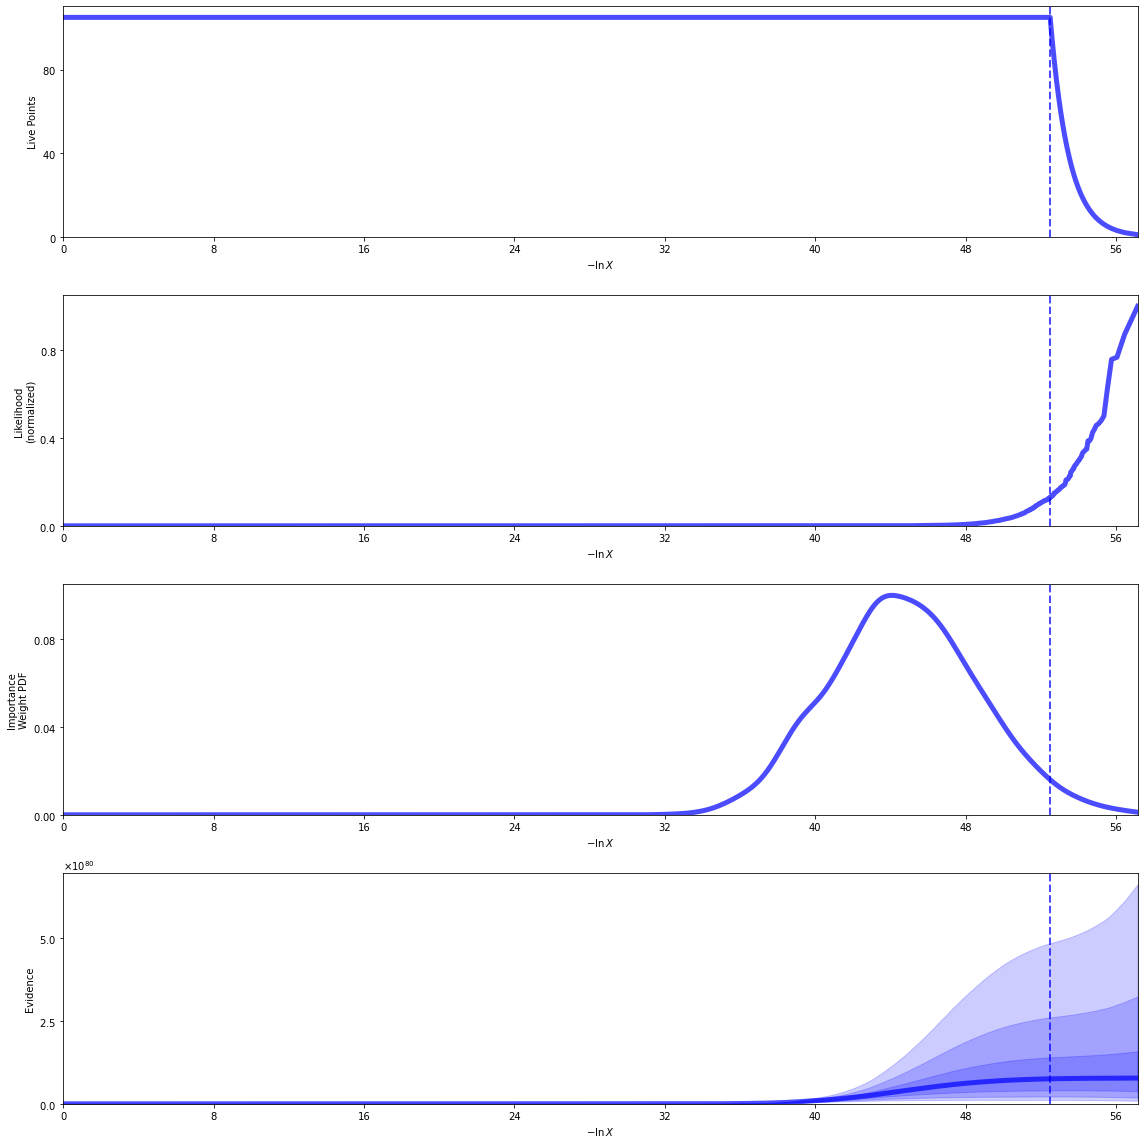

Quantiles:
$x_{1}$ [(0.025, -6.320980462987312), (0.5, -5.442380108642081), (0.975, -4.637511987120223)]
Quantiles:
$x_{2}$ [(0.025, -1.3706880558661283), (0.5, -0.513435927155537), (0.975, 0.1942448724246563)]
Quantiles:
$x_{3}$ [(0.025, -1.9560442131676448), (0.5, -1.3599160679236282), (0.975, -0.8949097836564937)]
Quantiles:
$x_{4}$ [(0.025, -2.1022199556952916), (0.5, -0.19612359125290832), (0.975, 1.5428323459277975)]
Quantiles:
$x_{5}$ [(0.025, -0.7128768832687584), (0.5, 0.2283083139912626), (0.975, 1.3935024405472891)]
Quantiles:
$x_{6}$ [(0.025, -0.41081876349188745), (0.5, 0.10074691617031338), (0.975, 0.7519186466589518)]
Quantiles:
$x_{7}$ [(0.025, -1.39800922284888), (0.5, 0.22147875581412774), (0.975, 1.727584753441025)]
Quantiles:
$x_{8}$ [(0.025, -0.9258032032253058), (0.5, 0.09207926712645317), (0.975, 1.343952458441323)]
Quantiles:
$x_{9}$ [(0.025, -0.5276140327043002), (0.5, -0.023939512419688856), (0.975, 0.5104136367854122)]
Quantiles:
$x_{10}$ [(0.025, -1.01932527

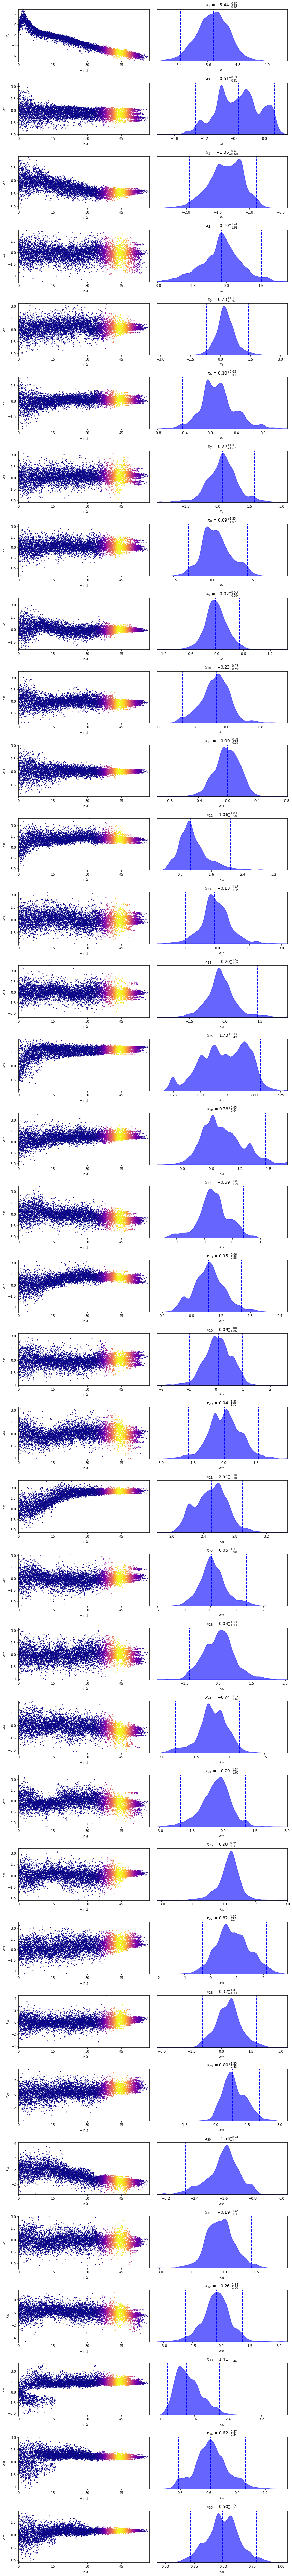

In [46]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

In [73]:
@jax.jit
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

0	log L = 229.01832839321924	SNR [dB] = 58.12449670641706
1	log L = 220.5227355765415	SNR [dB] = 57.64179812254962
2	log L = 225.290887736941	SNR [dB] = 56.8150041612589
3	log L = 230.56942495444952	SNR [dB] = 57.633156656160565
4	log L = 218.82622877224202	SNR [dB] = 56.14018406506797


DeviceArray(0.13204119, dtype=float64)

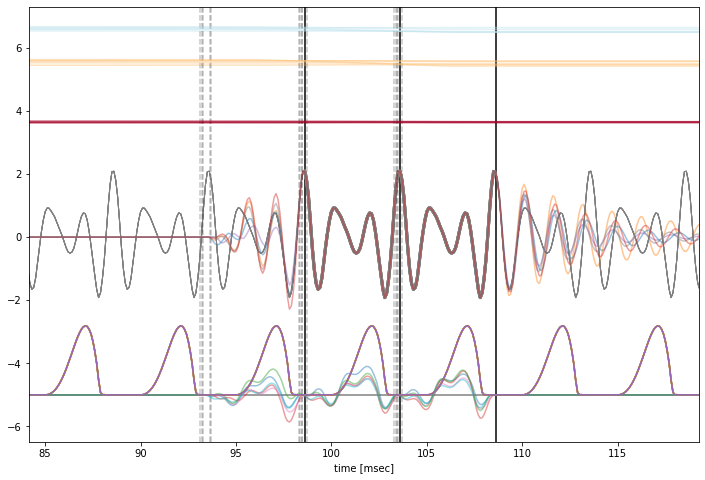

In [49]:
nsamp = 5

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    plot(hyper['data']['fullt'], hyper['data']['fullaux'] - 5, label="truth")
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf, .1)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [50]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.00155952, dtype=float64),
 DeviceArray(0.13204119, dtype=float64),
 {'Oq': DeviceArray([0.95975085, 0.97667063, 0.97045866], dtype=float64),
  'T': DeviceArray([5.20882675, 4.97787019, 4.97726347], dtype=float64),
  'r': DeviceArray([0.12949483, 0.12510169, 0.15282946], dtype=float64),
  'var_sigma': DeviceArray([0.84981703, 0.79922722, 0.94651667], dtype=float64)},
 {'g': DeviceArray([[1.97051865],
               [1.86636177],
               [1.59989681]], dtype=float64),
  'x': DeviceArray([[ 661.85763806, 2625.04939068, 3635.15096291],
               [ 645.75738948, 2534.81750178, 3574.68021462],
               [ 633.27817152, 2418.87260731, 3496.4538032 ]],            dtype=float64),
  'y': DeviceArray([[ 68.41224508, 532.33430609, 137.98445342],
               [ 67.09598088, 503.14746759, 126.04987669],
               [ 65.99933699, 475.25214592, 113.15103619]], dtype=float64)})

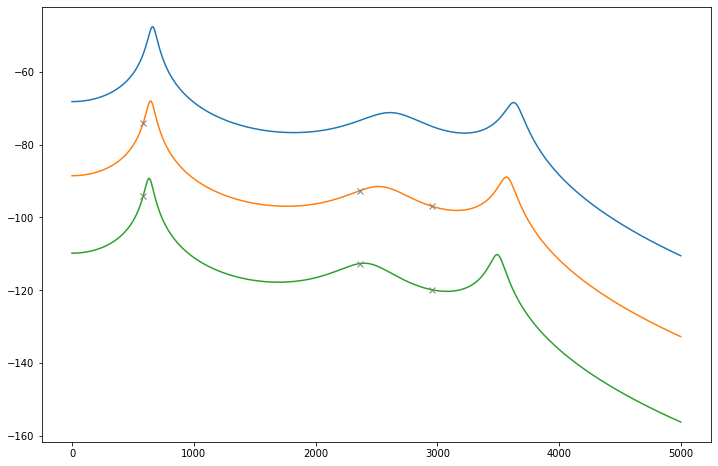

In [51]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")